The notebook was downloaded directly from Google Colab https://colab.research.google.com/drive/18rrA-Qs7jUEzbkyykFAg3Vh4pCpVTvKI?usp=sharing. If you'd like to run it as a local jupyter notebook, please change relevant file importing lines.

# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import pytz
from scipy.stats import skew, kurtosis
from functools import reduce
from datetime import datetime

# News data

## Documentation/Notes
- Data source frequency: Intraday
- Features we'd like to get: Daily
- We obtained the news data from two sources: Alpha Vantage and polygon.io. Alpha Vantage API only provides news entries starting 2022-03-02 but has more information. polygon.io includes all dates of interest but its news cover is much less comprehensive and it provides relatively limited information. So we decided to take advantage of both.
- The Alpha Vantage API documentation does not specify the time zone(s) of the "time_published". We looked into it and learned that they are utc time. This is important for feature engineering. For example, we came up a feature that describes the number of post-market news.
- At the end of the "news data" section, we would get a "news" dataframe with the following features: date, count_polygon, news_count_after_close_polygon, count, sentiment, news_count_after_close, bearish, bullish, neutral (columns ending with "_polygon" are polygon-related and the rest are alpha vantage-related).


In [ ]:
from google.colab import files
uploaded = files.upload()
# choose news_av1.csv through news_av9.csv AND news_polygon1.csv, news_polygon2.csv

In [ ]:
from numpy.core.multiarray import concatenate
temp = []
for i in range(1,10):
  filename = f'news_av{i}.csv'
  df = pd.read_csv(filename)
  temp.append(df)
df_news = pd.concat(temp, ignore_index=True)
df_news

,Headline,Summary,time_published,source,overall_sentiment_score,overall_sentiment_label,URL
0,NaN,London/Moscow ( CNN Business ) The Russian...,2022-03-02 08:00:00,CNN,-0.469431,Bearish,https://www.cnn.com/2022/03/02/business/russia...
1,NaN,"Lockheed (LMT) will procure, deliver, install ...",2022-03-04 14:57:00,Zacks Commentary,0.016660,Neutral,https://www.zacks.com/stock/news/1877583/lockh...
2,NaN,The Boeing Company (BA) clinches supply orders...,2022-03-07 13:50:00,Zacks Commentary,0.098672,Neutral,https://www.zacks.com/stock/news/1878344/boein...
3,NaN,The VIX is high and may not see relief until t...,2022-03-07 15:02:44,Forbes,-0.096865,Neutral,https://www.forbes.com/sites/jjkinahan/2022/03...
4,NaN,Lockheed (LMT) will integrate mission and weap...,2022-03-07 15:06:00,Zacks Commentary,0.019296,Neutral,https://www.zacks.com/stock/news/1878489/lockh...
...,...,...,...,...,...,...,...
6375,NaN,Northern Pacific Airways cancels second-ever s...,2023-07-19 19:49:00,Business Insider,-0.031143,Neutral,https://www.businessinsider.com/northern-pacif...
6376,NaN,The Directed Energy Weapons Market is to grow ...,2023-07-20 11:00:00,PR Newswire,0.080546,Neutral,https://www.prnewswire.com/news-releases/the-d...
6377,NaN,Boeing's (BA) Q2 results are likely to reflect...,2023-07-20 11:59:00,Zacks Commentary,0.174241,Somewhat-Bullish,https://www.zacks.com/stock/news/2124395/will-...
6378,NaN,"PURCHASE, N.Y., July 20, 2023 ( GLOBE NEWSWIRE...",2023-07-20 13:00:35,Benzinga,0.193724,Somewhat-Bullish,https://www.benzinga.com/pressreleases/23/07/g...


In [ ]:
df_news.dtypes

Headline                   float64
Summary                     object
time_published              object
source                      object
overall_sentiment_score    float64
overall_sentiment_label     object
URL                         object
dtype: object

In [ ]:
utc_zone = pytz.timezone('UTC')
et_zone = pytz.timezone('US/Eastern')
def convert_utc_to_et(utc_dt):
  utc_dt = utc_zone.localize(utc_dt)
  et_dt = utc_dt.astimezone(et_zone)
  return pd.to_datetime(et_dt.strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
df_news.drop_duplicates(inplace=True)
df_news['time_published'] = pd.to_datetime(df_news['time_published'])
df_news.sort_values('time_published', inplace=True)
df_news['time_published'] = df_news['time_published'].apply(convert_utc_to_et)
df_news['date'] = df_news['time_published'].dt.date


after_4pm_mask = df_news['time_published'].dt.hour >= 16
# after market (after 4pm) news, which are not reflected in the price/volume data of the day
df_news['after_4pm'] = after_4pm_mask

daily_data = df_news.groupby('date').agg(
    count=('time_published', 'size'),
    sentiment=('overall_sentiment_score', 'sum'),
    news_count_after_close=('after_4pm', 'sum')
)

daily_data['bearish'] = df_news[df_news['overall_sentiment_label'].str.contains('Bearish')].groupby('date').size() / daily_data['count']
daily_data['bullish'] = df_news[df_news['overall_sentiment_label'].str.contains('Bullish')].groupby('date').size() / daily_data['count']
daily_data['neutral'] = df_news[df_news['overall_sentiment_label'].str.contains('Neutral')].groupby('date').size() / daily_data['count']

daily_data.fillna(0, inplace=True)
daily_data.reset_index(inplace=True)

daily_data

,date,count,sentiment,news_count_after_close,bearish,bullish,neutral
0,2022-03-02,1,-0.469431,0,1.000,0.000000,0.000000
1,2022-03-04,1,0.016660,0,0.000,0.000000,1.000000
2,2022-03-07,6,-0.326019,1,0.000,0.000000,1.000000
3,2022-03-08,4,-0.200212,2,0.250,0.250000,0.500000
4,2022-03-09,5,-0.006799,0,0.000,0.000000,1.000000
...,...,...,...,...,...,...,...
472,2023-07-15,4,0.088657,0,0.000,0.250000,0.750000
473,2023-07-17,8,0.624693,3,0.125,0.500000,0.375000
474,2023-07-18,12,2.253843,1,0.000,0.666667,0.333333
475,2023-07-19,7,0.606386,0,0.000,0.142857,0.857143


In [ ]:
polygon1 = pd.read_csv('news_polygon1.csv')
polygon2 = pd.read_csv('news_polygon2.csv')
polygon = pd.concat([polygon1, polygon2], ignore_index=True)

polygon.drop_duplicates(inplace=True)
polygon['time_published'] = polygon['published_utc'].str[:-6]
polygon['time_published'] = pd.to_datetime(polygon['time_published'])
polygon.sort_values('time_published', inplace=True)
polygon['time_published'] = polygon['time_published'].apply(convert_utc_to_et)
polygon['date'] = polygon['time_published'].dt.date

after_4pm_mask = polygon['time_published'].dt.hour >= 16
polygon['after_4pm'] = after_4pm_mask

temp = polygon.groupby('date').agg(
    count_polygon=('time_published', 'size'),
    news_count_after_close_polygon=('after_4pm', 'sum')
)

temp.reset_index(inplace=True)
temp

,date,count_polygon,news_count_after_close_polygon
0,2020-06-30,1,0
1,2020-07-02,1,0
2,2020-07-28,1,0
3,2020-08-11,1,0
4,2020-10-17,1,0
...,...,...,...
622,2023-05-26,1,0
623,2023-05-27,1,0
624,2023-05-29,2,0
625,2023-05-31,2,0


In [ ]:
news = temp.merge(daily_data, on='date', how='outer')
news['date'] = pd.to_datetime(news['date'])
news = news.loc[(news['date'] >= '2020-05-28') & (news['date'] < '2023-06-02')]
news.isna().sum()

date                                0
count_polygon                      78
news_count_after_close_polygon     78
count                             276
sentiment                         276
news_count_after_close            276
bearish                           276
bullish                           276
neutral                           276
dtype: int64

In [ ]:
news

,date,count_polygon,news_count_after_close_polygon,count,sentiment,news_count_after_close,bearish,bullish,neutral
0,2020-06-30,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-07-02,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-07-28,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-08-11,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-10-17,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
700,2023-05-18,NaN,NaN,13.0,1.964691,0.0,0.000000,0.692308,0.307692
701,2023-05-19,NaN,NaN,30.0,4.963761,4.0,0.033333,0.500000,0.466667
702,2023-05-21,NaN,NaN,2.0,0.203602,1.0,0.000000,0.500000,0.500000
703,2023-05-28,NaN,NaN,6.0,0.257894,0.0,0.166667,0.166667,0.666667


# Price and volatility data

## Documentation/Notes
- Data source: Second level price data and half hour level volatility data provided to us by Professor Brini.
- Features we'd like to get: Daily
- **Our target/dependent variable**: 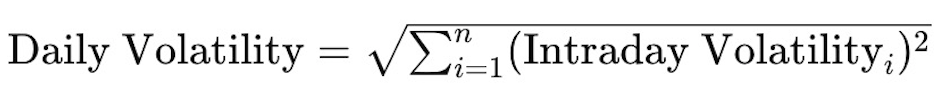
- Several ways of coming up features: lags, last hour's price/returns, last hour's volatility, short term price/returns to long term average price/returns ratio, short term volatility to long term average volatility ratio, skewness and kurtosis of price/returns/volatility.
- Through the short term to long term ratio, we are essentially trying to capture how much the "most recent" market deviates from its longer term average, which thereby provides a measure of the direction and the magnitude of change (aka "volatility").
- To get some of the price features, we obtained the 5-min level data from the second level price data first, extracting **the maximum, the minimum, the mean, and the last** data point of every 5-min interval. We did this because the second level data could be too arbitrary for some features. For example, let's say we'd like to get the last two hours' returns. If we use the second level data, we are gonna calculate the returns based on prices at 2:00:00pm and 4:00:00pm. Hmm...Why not 2:00:30pm and 4:00:00pm?

In [ ]:
from google.colab import files
uploaded = files.upload()
# choose BA.csv and BA_20_23.csv

Saving BA_20_23.csv to BA_20_23.csv
Saving BA.csv to BA.csv


In [ ]:
intraday_vol = pd.read_csv("BA.csv", index_col=0)
daily_vol = np.sqrt((intraday_vol**2).sum(axis=0))
last_hour_vol = np.sqrt((intraday_vol.iloc[-3:] ** 2).sum(axis=0))
last_hour_ratio = last_hour_vol/daily_vol

five_day_rolling_vol = daily_vol.rolling(window=5).mean()
last_hour_five_day_ratio = last_hour_vol / five_day_rolling_vol

intraday_range = intraday_vol.max(axis=0) - intraday_vol.min(axis=0)
intraday_skewness = intraday_vol.apply(skew, axis=0)
intraday_kurtosis = intraday_vol.apply(kurtosis, axis=0)

volatility = pd.DataFrame({
    'daily_vol': daily_vol,
    'last_hour_vol': last_hour_vol,
    'last_hour_ratio': last_hour_ratio,
    'last_hour_five_day_ratio': last_hour_five_day_ratio,
    'range': intraday_range.values,
    'skewness': intraday_skewness.values,
    'kurtosis': intraday_kurtosis.values
    })

# volatility['last_hour_five_day_ratio'].fillna(method='bfill', inplace=True)

for i in range(5):
    volatility['daily_vol_lag{}'.format(i+1)] = volatility['daily_vol'].shift(i+1)
volatility

,daily_vol,last_hour_vol,last_hour_ratio,last_hour_five_day_ratio,range,skewness,kurtosis,daily_vol_lag1,daily_vol_lag2,daily_vol_lag3,daily_vol_lag4,daily_vol_lag5
2020-06-01,0.004472,0.001702,0.380625,NaN,0.002160,0.656444,-1.153653,NaN,NaN,NaN,NaN,NaN
2020-06-02,0.003989,0.002123,0.532190,NaN,0.001800,0.972959,-0.680334,0.004472,NaN,NaN,NaN,NaN
2020-06-03,0.005349,0.002554,0.477551,NaN,0.001081,-0.217690,-0.995513,0.003989,0.004472,NaN,NaN,NaN
2020-06-04,0.011732,0.006618,0.564077,NaN,0.004388,1.022599,-0.202554,0.005349,0.003989,0.004472,NaN,NaN
2020-06-05,0.016798,0.008077,0.480812,0.953793,0.004638,0.085162,-1.121219,0.011732,0.005349,0.003989,0.004472,NaN
2020-06-08,0.013474,0.007080,0.525449,0.689484,0.006030,1.056844,-0.616453,0.016798,0.011732,0.005349,0.003989,0.004472
2020-06-09,0.016498,0.009044,0.548190,0.708214,0.008098,0.913105,-0.703989,0.013474,0.016798,0.011732,0.005349,0.003989
2020-06-10,0.016088,0.007988,0.496525,0.535474,0.004458,0.610975,-0.701578,0.016498,0.013474,0.016798,0.011732,0.005349
2020-06-11,0.024841,0.019775,0.796037,1.127401,0.012089,0.786440,-0.943614,0.016088,0.016498,0.013474,0.016798,0.011732
2020-06-12,0.016107,0.007572,0.470088,0.435114,0.003848,0.671607,-1.191991,0.024841,0.016088,0.016498,0.013474,0.016798


In [ ]:
intraday_price = pd.read_csv("BA_20_23.csv", index_col=0)

dummy_date = pd.to_datetime('2023-01-01')
intraday_price.index = pd.to_datetime(dummy_date.strftime('%Y-%m-%d') + ' ' + intraday_price.index)

df_resampled = intraday_price.resample('5T')

df_last = df_resampled.last()
df_high = df_resampled.max()
df_low = df_resampled.min()
df_mean = df_resampled.mean()

df_last.index = df_last.index.time
df_high.index = df_high.index.time
df_low.index = df_low.index.time
df_mean.index = df_mean.index.time

# df_last = np.log(df_last / df_last.shift(1))
# df_high = np.log(df_high / df_high.shift(1))
# df_low = np.log(df_low / df_low.shift(1))
# df_mean = np.log(df_mean / df_mean.shift(1))

df_mean

,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,...,2023-05-18,2023-05-19,2023-05-22,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-30,2023-05-31,2023-06-01
09:30:00,145.390867,154.458667,157.356800,181.781667,201.337967,221.095667,217.877233,210.683133,182.033383,185.376143,...,206.047533,207.688167,206.262800,204.603133,200.792333,198.735733,202.096333,204.958200,203.537083,206.846367
09:35:00,146.031433,153.994017,156.277333,184.872150,199.155867,222.284133,223.331167,207.410020,185.057147,188.305040,...,207.287233,207.483200,206.074233,204.113667,200.195333,197.820217,202.693733,204.099267,203.161467,208.059833
09:40:00,147.341067,154.514330,156.432300,183.114233,202.030083,226.104867,222.406300,205.050167,187.409097,189.471567,...,207.567133,206.904467,206.028150,204.519700,200.122900,197.549333,204.028950,204.175233,203.040433,208.198333
09:45:00,148.377333,154.705400,156.982400,179.343067,203.279417,226.938033,220.106270,203.885937,190.398667,187.201317,...,207.062667,206.392767,205.498383,204.923500,199.391567,198.691700,204.361200,204.719767,202.242200,207.343633
09:50:00,148.881667,154.289280,157.413333,180.135150,201.653600,227.147667,217.582650,204.641263,189.051117,186.355323,...,206.732833,206.457267,205.746133,205.788800,199.182267,198.923117,203.743500,204.968100,201.573500,206.782900
09:55:00,149.018233,154.875700,158.126833,180.989907,201.040867,228.631150,217.249700,204.304417,188.458480,187.660920,...,206.704333,206.698000,205.470467,206.269367,199.297267,199.759367,203.748250,204.628333,201.500033,206.292300
10:00:00,149.374150,154.944307,158.979780,181.838533,201.206670,228.422350,216.571933,204.321650,187.174700,188.886150,...,206.806000,206.598400,205.113400,206.449567,199.652300,200.478500,204.036250,204.073067,201.758367,206.683100
10:05:00,150.361017,155.054000,159.149033,182.412150,202.636517,228.753067,215.856097,203.991783,186.734667,188.691900,...,206.494967,206.721467,204.589000,206.273833,199.312983,199.848633,204.307950,204.070233,202.212000,207.154567
10:10:00,151.704100,155.264713,159.200467,180.567333,203.676417,229.479220,215.363230,202.405353,188.175717,188.541900,...,206.395633,206.500267,204.687350,206.193183,199.270833,199.381667,204.296050,204.289633,202.332800,207.447633
10:15:00,151.217633,155.081820,159.341167,181.079807,203.781397,232.308700,216.930103,199.987150,188.148917,187.278333,...,206.892967,206.372700,204.998433,205.885833,199.486467,199.871433,203.911933,205.299100,202.471033,207.808067


In [ ]:
def get_price_feats(day_prices):
  last_hour_return = np.log(day_prices.iloc[-1] / day_prices.iloc[-7])
  daily_ret = np.log(day_prices.iloc[-1] / day_prices.iloc[0])
  quasi_whole_day_return = np.log(day_prices.iloc[-7] / (day_prices.iloc[0] + 0.000001)) # add a small value so no divide by zero error
  last_hour_to_whole_day_ratio = last_hour_return / quasi_whole_day_return

  last_hour_prices = day_prices.iloc[-7:]
  skewness_last_hour = skew(last_hour_prices)
  kurtosis_last_hour = kurtosis(last_hour_prices)
  skewness_day = skew(day_prices)
  kurtosis_day = kurtosis(day_prices)

  return last_hour_return, daily_ret, last_hour_to_whole_day_ratio, skewness_last_hour, kurtosis_last_hour, skewness_day, kurtosis_day

def get_ret_feats(day_ret):
  ret_skew = day_ret.apply(skew, axis=0, nan_policy='omit')
  ret_kurt = day_ret.apply(kurtosis, axis=0, nan_policy='omit')
  return ret_skew, ret_kurt

In [ ]:
def get_all_feats(df_price, name):
  last_hour_return, daily_ret, last_hour_to_whole_day_ratio, skewness_last_hour, kurtosis_last_hour, skewness_day, kurtosis_day \
= get_price_feats(df_price)
  ret = np.log(df_price / df_price.shift(1))
  price = df_price.apply(get_price_feats)
  price.index = ['last_hour_ret', 'daily_ret', 'last_hour_whole_day_ret_ratio', 'skewness_last_hour', 'kurtosis_last_hour', 'skewness_day', 'kurtosis_day']
  price = price.T

  rolling_mean_5day = price['daily_ret'].rolling(window=6).mean().shift(1)
  price['daily_ret_to_mean_5day_ret'] = price['daily_ret'] / rolling_mean_5day.replace(0, np.nan)
  price['skew_ret'] = get_ret_feats(ret)[0]
  price['kurt_ret'] = get_ret_feats(ret)[1]

  for i in range(5):
      price['daily_ret_lag{}'.format(i+1)] = price['daily_ret'].shift(i+1)

  new_columns = {col: f"{name}_{col}" for col in price.columns}
  price.rename(columns=new_columns, inplace=True)

  return price

price1 = get_all_feats(df_last, 'last')
price2 = get_all_feats(df_high, 'high')
price3 = get_all_feats(df_mean, 'mean')
price4 = get_all_feats(df_low, 'low')
price = pd.concat([price1, price2, price3, price4, volatility], axis=1)

<ipython-input-34-2ff2ea0080a0>:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness_last_hour = skew(last_hour_prices)
<ipython-input-34-2ff2ea0080a0>:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis_last_hour = kurtosis(last_hour_prices)
<ipython-input-34-2ff2ea0080a0>:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness_last_hour = skew(last_hour_prices)
<ipython-input-34-2ff2ea0080a0>:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis_last_hour = kurtosis(la

In [ ]:
# price.isna().sum()
price.bfill(inplace=True)
price

,last_last_hour_ret,last_daily_ret,last_last_hour_whole_day_ret_ratio,last_skewness_last_hour,last_kurtosis_last_hour,last_skewness_day,last_kurtosis_day,last_daily_ret_to_mean_5day_ret,last_skew_ret,last_kurt_ret,...,last_hour_ratio,last_hour_five_day_ratio,range,skewness,kurtosis,daily_vol_lag1,daily_vol_lag2,daily_vol_lag3,daily_vol_lag4,daily_vol_lag5
2020-06-01,-0.001650,0.039958,-0.039656,-0.168718,-0.684330,-2.634540,9.141257,-0.549845,0.188619,2.124287,...,0.380625,0.953793,0.002160,0.656444,-1.153653,0.004472,0.004472,0.004472,0.004472,0.004472
2020-06-02,0.000261,-0.012830,-0.019930,-0.385112,-0.739096,0.030237,-0.666680,-0.549845,-0.463435,6.585963,...,0.532190,0.953793,0.001800,0.972959,-0.680334,0.004472,0.004472,0.004472,0.004472,0.004472
2020-06-03,0.001388,0.094779,0.014859,0.107699,-1.251680,-0.606446,-0.420104,-0.549845,0.354787,1.588838,...,0.477551,0.953793,0.001081,-0.217690,-0.995513,0.003989,0.004472,0.004472,0.004472,0.004472
2020-06-04,0.002282,-0.002006,-0.532179,-0.461983,-0.604057,-0.633974,0.900400,-0.549845,-0.368956,1.681584,...,0.564077,0.953793,0.004388,1.022599,-0.202554,0.005349,0.003989,0.004472,0.004472,0.004472
2020-06-05,0.008619,0.023735,0.570245,-0.497251,-1.175441,0.182250,-1.229666,-0.549845,0.453794,0.204070,...,0.480812,0.953793,0.004638,0.085162,-1.121219,0.011732,0.005349,0.003989,0.004472,0.004472
2020-06-08,0.001650,0.048940,0.034887,0.813834,-0.844402,-2.155872,12.635737,-0.549845,1.968290,7.540688,...,0.525449,0.689484,0.006030,1.056844,-0.616453,0.016798,0.011732,0.005349,0.003989,0.004472
2020-06-09,-0.004969,-0.017648,0.391934,-0.198372,-1.307985,-0.026560,-0.716753,-0.549845,0.627835,3.198337,...,0.548190,0.708214,0.008098,0.913105,-0.703989,0.013474,0.016798,0.011732,0.005349,0.003989
2020-06-10,-0.018362,-0.025958,2.417217,0.435288,-1.016629,-0.454132,-0.237103,-1.153942,-0.510241,1.333401,...,0.496525,0.535474,0.004458,0.610975,-0.701578,0.016498,0.013474,0.016798,0.011732,0.005349
2020-06-11,0.004483,-0.079667,-0.053274,0.522347,-1.224918,-0.791252,-0.052765,-3.923137,0.584880,2.460890,...,0.796037,1.127401,0.012089,0.786440,-0.943614,0.016088,0.016498,0.013474,0.016798,0.011732
2020-06-12,0.015154,0.019449,3.527998,-0.301104,-1.655049,-0.179771,-0.162252,-2.218361,0.064400,0.537292,...,0.470088,0.435114,0.003848,0.671607,-1.191991,0.024841,0.016088,0.016498,0.013474,0.016798


# Other data

## Documentation/Notes
- Data source frequency: Daily, monthly, and quarterly
- Features we'd like to get: Daily
- Daily: VIX (including open, high, low, close), Volume, 10y/1y/1m yields, Dow Jones Industrial Average Index, S&P Aerospace & Defense Select Industry Index, Brent Crude Oil Price
- Monthly: Fed funds rate, CPI (including the percentage change and the absolute value), Orders and Deliveries (there were no data after March 2022, but it is the recent data that we need so we ended up not using this)
- Quarterly: EPS (dates associated are the report dates, not the quarters EPS refers to)
- Data filled on a daily basis based on the previous value until we meet the next value



In [ ]:
from google.colab import files
uploaded = files.upload()
# choose the rest in the folder

Saving ^VIX.csv to ^VIX.csv
Saving BA.csv to BA (1).csv
Saving CPI.csv to CPI.csv
Saving DCOILBRENTEU.csv to DCOILBRENTEU.csv
Saving dowjones.csv to dowjones.csv
Saving EPS.csv to EPS.csv
Saving FEDFUNDS.csv to FEDFUNDS.csv
Saving industry_index.csv to industry_index.csv
Saving OrdersandDeliveries.csv to OrdersandDeliveries.csv
Saving yield.csv to yield.csv


- EPS	quarterly	Y
- FEDFUNDS	Monthly	Y
- 10y, 1y, 1m yields	daily	Y
- volume	daily	Y
- VIX	daily	Y
- Dow Jones Industrial Average	daily	Y
- S&P Aerospace & Defense Select Industry Index	daily	Y
- CPI	Monthly	Y
- Crude oil - Brent	daily	Y
- Orders and Deliveries	Monthly	N

In [ ]:
VIX = pd.read_csv("^VIX.csv")
yields = pd.read_csv('yield.csv')
volume = pd.read_csv('BA (1).csv')
dowjones = pd.read_csv('dowjones.csv')
industry_index = pd.read_csv('industry_index.csv')
oil = pd.read_csv('DCOILBRENTEU.csv')

print(VIX.columns)
print(yields.columns)
print(volume.columns)
print(dowjones.columns)
print(industry_index.columns)
print(oil.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['DATE', '10Y', '1Y', '4W'], dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Date', 'Dow Jones Industrial Average Close'], dtype='object')
Index(['date', 'Industry_Index', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'],
      dtype='object')
Index(['DATE', 'DCOILBRENTEU'], dtype='object')


In [ ]:
VIX.drop('Volume', axis=1, inplace=True)
volume = volume[['Date', 'Volume']]
industry_index = industry_index[['date', 'Industry_Index']]
industry_index.rename(columns={"date": "Date"}, inplace=True)
yields.rename(columns={"DATE": "Date"}, inplace=True)
oil.rename(columns={"DATE": "Date"}, inplace=True)
VIX.rename(columns={'Open': 'VIX_open', 'High': 'VIX_high', 'Low': 'VIX_low',
                    'Close Adj': 'VIX_adjclose', 'Close': 'VIX_close'}, inplace=True)
dfs = [VIX, yields, volume, dowjones, industry_index, oil]

<ipython-input-20-beafa2147e11>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_index.rename(columns={"date": "Date"}, inplace=True)


In [ ]:
for i in dfs:
  i['Date'] = pd.to_datetime(i.Date)
  i['Date'] = i['Date'].dt.strftime('%Y-%m-%d')
  i.sort_values(by='Date')

daily = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), dfs)
daily = daily.loc[(daily['Date'] >= '2020-05-28') & (daily['Date'] < '2023-06-02')]
daily.sort_values(by='Date', inplace=True)
daily['10Y'] = pd.to_numeric(daily['10Y'], errors='coerce')
daily['1Y'] = pd.to_numeric(daily['1Y'], errors='coerce')
daily['4W'] = pd.to_numeric(daily['4W'], errors='coerce')
daily.bfill(inplace=True)
daily.ffill(inplace=True)
daily['Date'] = pd.to_datetime(daily['Date'])
daily

,Date,VIX_open,VIX_high,VIX_low,VIX_close,Adj Close,10Y,1Y,4W,Volume,Dow Jones Industrial Average Close,Industry_Index,DCOILBRENTEU
1191,2020-05-28,28.940001,30.600000,28.110001,28.230000,28.230000,0.70,0.17,0.14,27127300.0,25383.11,13543.16,36.74
1192,2020-05-29,28.940001,30.600000,28.110001,28.230000,28.230000,0.65,0.17,0.13,27127300.0,25383.11,13543.16,36.74
0,2020-06-01,28.940001,30.600000,28.110001,28.230000,28.230000,0.66,0.17,0.12,27127300.0,25475.02,13769.95,36.74
1,2020-06-02,28.400000,28.520000,26.660000,26.840000,26.840000,0.68,0.17,0.12,24780500.0,25742.65,13871.76,37.72
2,2020-06-03,26.750000,26.980000,25.040001,25.660000,25.660000,0.77,0.17,0.12,66486400.0,26269.89,14443.11,37.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,2023-05-26,19.070000,19.559999,17.270000,17.950001,17.950001,3.80,4.98,5.78,3820300.0,33093.34,17245.22,76.33
780,2023-05-29,17.559999,18.340000,16.980000,17.459999,17.459999,3.69,4.97,5.12,3978200.0,33042.78,17244.29,.
781,2023-05-30,17.559999,18.340000,16.980000,17.459999,17.459999,3.69,4.97,5.12,3978200.0,33042.78,17244.29,73.38
782,2023-05-31,18.040001,18.400000,17.120001,17.940001,17.940001,3.64,4.94,5.08,5461600.0,32908.27,17123.92,71.98


In [ ]:
CPI = pd.read_csv("CPI.csv")
EPS = pd.read_csv('EPS.csv')
fund_rate = pd.read_csv('FEDFUNDS.csv')
orders = pd.read_csv('OrdersandDeliveries.csv')

print(CPI.columns)
print(EPS.columns)
print(fund_rate.columns)
print(orders.columns)

Index(['date', 'CPI_12_month_pct', 'CPI'], dtype='object')
Index(['report_date', 'eps', 'quarter', 'beat_expected'], dtype='object')
Index(['DATE', 'FEDFUNDS'], dtype='object')
Index(['Country', 'Customer Name', 'Delivery Year ', 'Engine', 'Model Series',
       'Order Month', 'Order Year', 'Region', 'Delivery Total', 'Order Total',
       'Unfilled Orders'],
      dtype='object')


In [ ]:
orders = orders.iloc[:-1, :]
orders['Date'] = pd.to_datetime(orders['Order Year'].astype(str) + '-' + orders['Order Month'], format='%Y-%b')
orders = orders.loc[(orders['Date'] >= '2020-05-28') & (orders['Date'] < '2023-06-02')]
orders['Order Total'] = pd.to_numeric(orders['Order Total'], errors='coerce')
orders['Delivery Total'] = pd.to_numeric(orders['Delivery Total'], errors='coerce')
orders['Order Total'].fillna(0, inplace=True)
orders['Delivery Total'].fillna(0, inplace=True)
grouped = orders.groupby('Date')
df_orders = grouped.agg({'Order Total': 'sum', 'Delivery Total': 'sum'}).reset_index()
df_orders

<ipython-input-23-c795a7374b3b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['Date'] = pd.to_datetime(orders['Order Year'].astype(str) + '-' + orders['Order Month'], format='%Y-%b')


,Date,Order Total,Delivery Total
0,2020-06-01,1,0
1,2020-08-01,8,6
2,2020-11-01,27,0
3,2020-12-01,90,8
4,2021-01-01,4,0
5,2021-02-01,82,5
6,2021-03-01,196,20
7,2021-04-01,25,15
8,2021-05-01,73,9
9,2021-06-01,219,0


In [ ]:
CPI.rename(columns={"date": "Date"}, inplace=True)
EPS.rename(columns={"report_date": "Date"}, inplace=True)
fund_rate.rename(columns={"DATE": "Date"}, inplace=True)
EPS.drop('quarter', axis=1, inplace=True)
dfs = [CPI, EPS, fund_rate]

updated_dfs = []
for i in dfs:
  try:
    i['Date'] = pd.to_datetime(i['Date'], format='%m/%d/%y')
  except:
    i['Date'] = pd.to_datetime(i['Date'], format='%Y/%m/%d')
  updated = i.loc[(i['Date'] >= '2020-04-02') & (i['Date'] < '2023-06-02')]
  updated_dfs.append(updated)

In [ ]:
def ffill_daily(df, start_date, end_date='2023-06-01'):
  end_date = pd.to_datetime(end_date)
  daily_df = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='D'), columns=['Date'])
  daily_df = daily_df.merge(df, on='Date', how='left')
  daily_df.ffill(inplace=True)
  return daily_df

start_CPI = CPI['Date'].min()
start_EPS = EPS['Date'].min()
start_rate = fund_rate['Date'].min()

CPI = ffill_daily(CPI, start_CPI)
EPS = ffill_daily(EPS, start_EPS)
fund_rate = ffill_daily(fund_rate, start_rate)

dfs = [CPI, EPS, fund_rate]

monthly = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), dfs)
monthly = monthly.loc[(monthly['Date'] >= '2020-04-02') & (monthly['Date'] < '2023-06-02')]
monthly

,Date,CPI_12_month_pct,CPI,eps,beat_expected,FEDFUNDS
0,2020-05-01,1.2,255.868,-1.11,0.0,0.05
1,2020-05-02,1.2,255.868,-1.11,0.0,0.05
2,2020-05-03,1.2,255.868,-1.11,0.0,0.05
3,2020-05-04,1.2,255.868,-1.11,0.0,0.05
4,2020-05-05,1.2,255.868,-1.11,0.0,0.05
...,...,...,...,...,...,...
25168,2020-04-24,NaN,NaN,NaN,NaN,0.05
25169,2020-04-25,NaN,NaN,NaN,NaN,0.05
25170,2020-04-26,NaN,NaN,NaN,NaN,0.05
25171,2020-04-27,NaN,NaN,NaN,NaN,0.05


In [ ]:
monthly = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), dfs)
monthly = monthly.loc[(monthly['Date'] >= '2020-05-28') & (monthly['Date'] < '2023-06-02')]
monthly.sort_values(by='Date', inplace=True)
monthly.ffill(inplace=True)
monthly.bfill(inplace=True)
monthly

,Date,CPI_12_month_pct,CPI,eps,beat_expected,FEDFUNDS
27,2020-05-28,1.2,255.868,-1.11,0.0,0.05
28,2020-05-29,1.2,255.868,-1.11,0.0,0.05
29,2020-05-30,1.2,255.868,-1.11,0.0,0.05
30,2020-05-31,1.2,255.868,-1.11,0.0,0.05
31,2020-06-01,1.2,256.986,-1.11,0.0,0.08
...,...,...,...,...,...,...
1122,2023-05-28,5.3,303.294,-0.69,0.0,5.06
1123,2023-05-29,5.3,303.294,-0.69,0.0,5.06
1124,2023-05-30,5.3,303.294,-0.69,0.0,5.06
1125,2023-05-31,5.3,303.294,-0.69,0.0,5.06


In [ ]:
others = daily.merge(monthly, on='Date', how='left')
others.isna().sum()

Date                                  0
VIX_open                              0
VIX_high                              0
VIX_low                               0
VIX_close                             0
Adj Close                             0
10Y                                   0
1Y                                    0
4W                                    0
Volume                                0
Dow Jones Industrial Average Close    0
Industry_Index                        0
DCOILBRENTEU                          0
CPI_12_month_pct                      0
CPI                                   0
eps                                   0
beat_expected                         0
FEDFUNDS                              0
dtype: int64

# Combine

In [ ]:
price = price.reset_index().rename(columns={'index': 'Date'})
news.rename(columns={'date': 'Date'}, inplace=True)
# price = price.iloc[:-6,:]
price['Date'] = pd.to_datetime(price['Date'])
df_all = pd.merge(price, others, on='Date', how='left')
df_all = pd.merge(df_all, news, on='Date', how='left')
df_all

,Date,last_last_hour_ret,last_daily_ret,last_last_hour_whole_day_ret_ratio,last_skewness_last_hour,last_kurtosis_last_hour,last_skewness_day,last_kurtosis_day,last_daily_ret_to_mean_5day_ret,last_skew_ret,...,beat_expected,FEDFUNDS,count_polygon,news_count_after_close_polygon,count,sentiment,news_count_after_close,bearish,bullish,neutral
0,2020-06-01,-0.001650,0.039958,-0.039656,-0.168718,-0.684330,-2.634540,9.141257,-0.549845,0.188619,...,0.0,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-02,0.000261,-0.012830,-0.019930,-0.385112,-0.739096,0.030237,-0.666680,-0.549845,-0.463435,...,0.0,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-06-03,0.001388,0.094779,0.014859,0.107699,-1.251680,-0.606446,-0.420104,-0.549845,0.354787,...,0.0,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-06-04,0.002282,-0.002006,-0.532179,-0.461983,-0.604057,-0.633974,0.900400,-0.549845,-0.368956,...,0.0,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-06-05,0.008619,0.023735,0.570245,-0.497251,-1.175441,0.182250,-1.229666,-0.549845,0.453794,...,0.0,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-06-08,0.001650,0.048940,0.034887,0.813834,-0.844402,-2.155872,12.635737,-0.549845,1.968290,...,0.0,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-06-09,-0.004969,-0.017648,0.391934,-0.198372,-1.307985,-0.026560,-0.716753,-0.549845,0.627835,...,0.0,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-06-10,-0.018362,-0.025958,2.417217,0.435288,-1.016629,-0.454132,-0.237103,-1.153942,-0.510241,...,0.0,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-06-11,0.004483,-0.079667,-0.053274,0.522347,-1.224918,-0.791252,-0.052765,-3.923137,0.584880,...,0.0,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-06-12,0.015154,0.019449,3.527998,-0.301104,-1.655049,-0.179771,-0.162252,-2.218361,0.064400,...,0.0,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_all['count_polygon'].fillna(0, inplace=True)
df_all['news_count_after_close_polygon'].fillna(0, inplace=True)

In [ ]:
pd.set_option('display.max_rows', None)
df_all.isna().sum()

Date                                    0
last_last_hour_ret                      0
last_daily_ret                          0
last_last_hour_whole_day_ret_ratio      0
last_skewness_last_hour                 0
last_kurtosis_last_hour                 0
last_skewness_day                       0
last_kurtosis_day                       0
last_daily_ret_to_mean_5day_ret         0
last_skew_ret                           0
last_kurt_ret                           0
last_daily_ret_lag1                     0
last_daily_ret_lag2                     0
last_daily_ret_lag3                     0
last_daily_ret_lag4                     0
last_daily_ret_lag5                     0
high_last_hour_ret                      0
high_daily_ret                          0
high_last_hour_whole_day_ret_ratio      0
high_skewness_last_hour                 0
high_kurtosis_last_hour                 0
high_skewness_day                       0
high_kurtosis_day                       0
high_daily_ret_to_mean_5day_ret   

In [ ]:
df_all.to_csv('features.csv')